# PCA (Principal Component Analysis) with Iris data

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will use the training and testing sets obtained in a previous notebook for the iris dataset. These are already scaled, since it is a PCA requirement.

In [3]:
X_train = pd.read_pickle('/content/drive/My Drive/IAAE/data/iris_Xtrain_sc.pkl')
y_train = pd.read_pickle('/content/drive/My Drive/IAAE/data/iris_ytrain.pkl')
X_test = pd.read_pickle('/content/drive/My Drive/IAAE/data/iris_Xtest_sc.pkl')
y_test = pd.read_pickle('/content/drive/My Drive/IAAE/data/iris_ytest.pkl')

Create an instance of the PCA class, fit to the training data and transform it.

In [4]:
pca = PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

Lets take a look at the first rows of the transformed data.

In [5]:
X_train_pca[:5]

array([[-2.36133751, -0.31026999,  0.09295489, -0.05526879],
       [ 1.64073462,  0.86956944,  0.33163853, -0.04968568],
       [ 1.0926834 , -0.83800665,  0.48388544, -0.04166265],
       [-2.60137921, -0.88157899,  0.10854664, -0.03144249],
       [ 0.84829201, -0.09608902, -0.57013297, -0.0519164 ]])

The result is a numpy array. Let's add column names and convert it to dataframe to be able to use the sns library. Each column of the dataframe is a principal component.

We can skip this step and work directly with the numpy array if we are not using any function that requires dataframes. 

In [6]:
lcolumns = []
for i in range (1,X_train.shape[1]+1):
  lcolumns.append('pc' + str(i))
df_pca = pd.DataFrame(X_train_pca, columns = lcolumns,index=X_train.index)

In [7]:
df_pca

,pc1,pc2,pc3,pc4
47,-2.361338,-0.310270,0.092955,-0.055269
124,1.640735,0.869569,0.331639,-0.049686
101,1.092683,-0.838007,0.483885,-0.041663
13,-2.601379,-0.881579,0.108547,-0.031442
58,0.848292,-0.096089,-0.570133,-0.051916
...,...,...,...,...
48,-2.188431,1.082825,-0.160699,-0.015188
70,0.705470,0.304664,0.605469,-0.069209
109,2.199749,1.754996,0.465123,0.125529
42,-2.512424,-0.392267,0.247686,-0.069382


Add the column with the class labels for the plot.

In [8]:
df_pca['class'] = y_train

Plot the 2 first PCs and check how well the natural structure of the data matches up with the given classes.

In this case, only two PCs are able to yield a good separation of the three classes, but this has not always to be the case, since PCA is an unsupervised method.

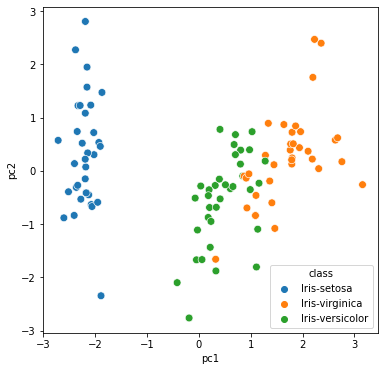

In [9]:
plt.figure(figsize=(6,6))
sns.scatterplot( x='pc1', y='pc2',s=60,
  data=df_pca, hue='class',legend=True);

Check the variance explained by each principal component


In [10]:
exp_var_pca = pca.explained_variance_ratio_
exp_var_pca

array([0.71794927, 0.24075005, 0.03660159, 0.00469909])

Create an array with the cumulative variance.

In [11]:
exp_var_pca_cumsum = np.cumsum(exp_var_pca)
exp_var_pca_cumsum

array([0.71794927, 0.95869932, 0.99530091, 1.        ])

Convert the arrays to a dataframe.

In [12]:
# np.arange generates consecutive numbers starting from 1 to represent the PCs
array_cumsum = {'Cum. variance %':exp_var_pca_cumsum,'PC':np.arange(1,len(lcolumns)+1)}
df_var_cumsum = pd.DataFrame(array_cumsum)

array_var_exp =  {'Cum. variance %':exp_var_pca,'PC':np.arange(1,len(lcolumns)+1)}
df_var_exp = pd.DataFrame(array_var_exp)

Plot the individual and cumulative variance of the PCs.

<Axes: xlabel='PC', ylabel='Cum. variance %'>

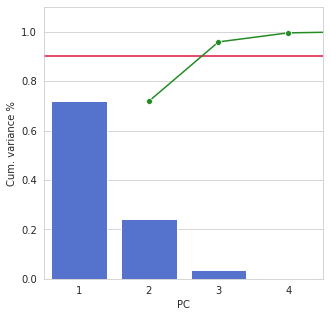

In [13]:
sns.set_style('whitegrid')
plt.figure(figsize=(5,5))
plt.ylim(0.0,1.1)
plt.xlim(0,5)
plt.xticks(np.arange(1, 5, step=1))
palette = ['royalblue'] * 4
plt.axhline(y=0.90, color='crimson', linestyle='-') #horizontal line at 90% of variance
sns.lineplot(data=df_var_cumsum,x='PC',y='Cum. variance %',marker='o', color='forestgreen')
sns.barplot(data=df_var_exp, x='PC', y='Cum. variance %', palette=palette)

From the plot and looking at the numbers, 2 PCs explain almost 96% of the variance of this data and 3 PCs almost 100%.

## Using PCs as input to a classification model

If we want to use the PCs instead of the original features for classification, we have to transform the test set but using the result of the fit for the training set.

In [14]:
X_test_pca = pca.transform(X_test)

In [15]:
X_test_pca = pd.DataFrame(X_test_pca, columns = lcolumns,index=X_test.index)

Let's use only the first 2 PCs as variables for building the model.

In [16]:
X_train_pca = df_pca[['pc1','pc2']]
X_test_pca = X_test_pca[['pc1','pc2']]

As an example, we build a kNN model using k=7. This is simply a projected version of the original dataset using the PCs as features and we treat it as any other dataset. Remember that in order to find the best value for the hyperparameter, we should run a grid search on the training set.

In [17]:
knn_mod = KNeighborsClassifier(n_neighbors=7)
knn_mod.fit(X_train_pca,y_train)
y_pred = knn_mod.predict(X_test_pca)
acc = accuracy_score(y_test,y_pred).round(2)
print('Accuracy:',acc)

Accuracy: 0.96


In [18]:
from sklearn.manifold import TSNE

# t-SNE with Mammographic Mass Dataset

As opposed to PCA, ``sklearn`` does not provide a ``transform`` method for t-SNE and we cannot learn a transformation and apply it to different data as the training and testing sets.

Because of that, we load the full dataset and apply t-SNE only to visualize the data in two dimensions.

In [19]:
columns_names = ['BI-RADS','Age','Shape','Margin','Density','Severity']
df_mamma = pd.read_csv('/content/drive/My Drive/IAAE/data/mamma.data.txt',names=columns_names)

Remember that these dataset required some preprocessing that we performed in a different notebook. Since the goal here is to provide an example of using t-SNE, we will simply remove missing values, make some data type conversions and encode nominal values.

In [20]:
df_mamma = df_mamma.replace('?',np.nan)
df_mamma = df_mamma.dropna()

In [21]:
df_mamma['Density'] = df_mamma['Density'].astype('float64')
df_mamma['Age'] = df_mamma['Age'].astype('float64')
df_mamma = pd.get_dummies(df_mamma, columns=['Shape','Margin'])

We only want the predictive variables. ``Severity`` is the class to predict and, by the dataset description, we know that ``BI-RADS`` has not to be used as a predictor.

In [22]:
X = df_mamma.drop(['BI-RADS','Severity'],axis=1)
y = df_mamma['Severity']

Create an instance of the TSNE class, fit and transform the data.



In [23]:
tsne = TSNE()
X_tsne = tsne.fit_transform(X)

We give names to the components and convert the result to a dataframe.

In [24]:
dicc_tsne = {'comp_1':X_tsne[:,0],'comp_2':X_tsne[:,1]}
df_tsne = pd.DataFrame(dicc_tsne,index=X.index)

Lets plot the data in the new space together with the original labels.

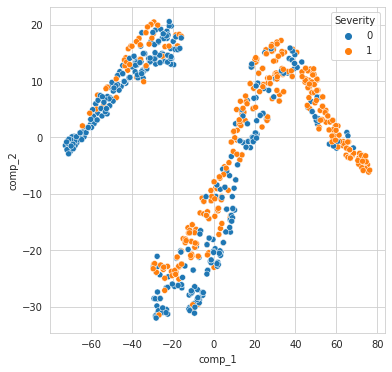

In [25]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_tsne, x='comp_1',y='comp_2', hue=y, legend='full');

We used the default value for the perplexity parameter. We now check how the data looks with several alternative values.

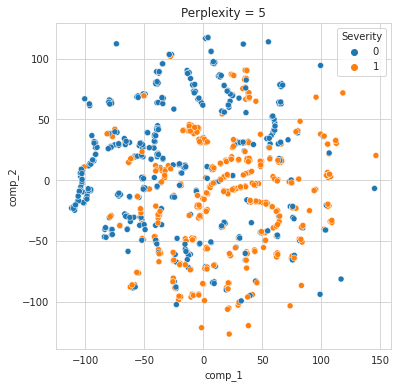

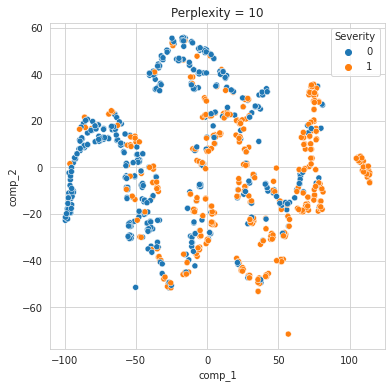

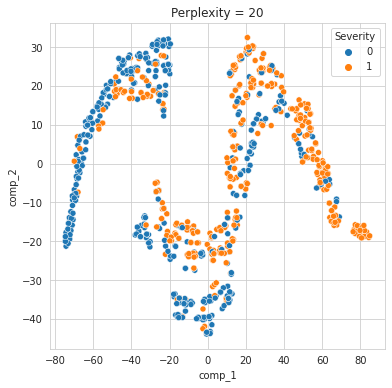

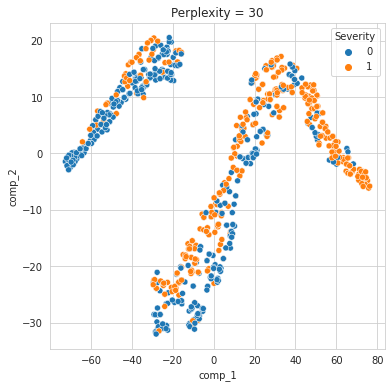

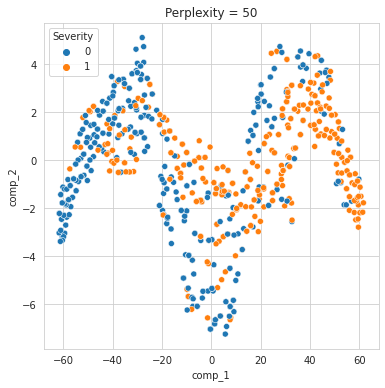

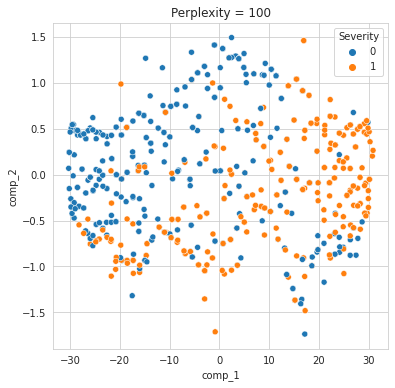

In [26]:
for perp in [5,10,20,30,50,100]:
  tsne = TSNE(perplexity=perp,random_state=72)
  X_tsne = tsne.fit_transform(X)
  dicc_tsne = {'comp_1':X_tsne[:,0],'comp_2':X_tsne[:,1]}
  df_tsne = pd.DataFrame(dicc_tsne,index=X.index)
  plt.figure(figsize=(6,6))
  plt.title('Perplexity = ' + str(perp))
  sns.scatterplot(data=df_tsne, x='comp_1',y='comp_2', hue=y, legend='full');